In [1]:
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm_api
from sklearn import preprocessing
from scipy.stats import chi2_contingency

In [2]:
df  = pd.read_csv(r'/home/silva/Downloads/lista_empregados2.csv')

In [3]:
df_perfil = df

#Ajusta código empregado
df_perfil['COD_EMPREGADO'] = df_perfil['COD_EMPREGADO'].apply(str)
df_perfil['COD_EMPREGADO'] = 'B' + df_perfil['COD_EMPREGADO']

#Filtra colunas
df_perfil = df_perfil[['COD_EMPREGADO', 'DATA_ADMISSAO', 'DATA_NASCIMENTO', 'NIVEL_FUNCAO', 'EST_CIVIL', 'SEXO', 'DEP_CRECHE_BABA']]

#modifica tipo coluna
df_perfil['DATA_NASCIMENTO'] = df_perfil['DATA_NASCIMENTO'].apply(pd.to_datetime)
df_perfil['DATA_ADMISSAO'] = df_perfil['DATA_ADMISSAO'].apply(pd.to_datetime)

#Calcular tempo/idade
ano_hoje = pd.datetime.today().year
df_perfil['TEMPO_EMPRESA'] = ano_hoje -  df_perfil['DATA_ADMISSAO'].dt.year 
df_perfil['IDADE'] = ano_hoje - df_perfil['DATA_NASCIMENTO'].dt.year
df_perfil['COD_USUARIO'] = df_perfil['COD_EMPREGADO']

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [63]:
#Cria classe
def cria_classe(valor, media, classe_abaixo, classe_acima):
    if valor > media:
        return classe_acima
    return classe_abaixo

#Boxplot
def plot_boxplot(df_class, df_features_standardized, w, h, classe):
    df_standardized = pd.concat([df_class,df_features_standardized],axis=1)
    df_melted = pd.melt(df_standardized,
                    id_vars=classe,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(w,h))
    sns.boxplot(x="features", y="value", hue=classe, data=df_melted)
    
def binning(col, method='doane'):
    hist, bin_edges = np.histogram(col, method)
    bined_values = np.digitize(col, bin_edges)
    bin_interval = list()
    for x in range(0, len(bin_edges)):
        if x == 0:
            bin_interval.append('(-Inf,{0})'.format(bin_edges[x]))
        elif x == (len(bin_edges) - 1):
            # bin_interval.append('({0},Inf)'.format(bin_edges[x]))
            continue
        else:
            bin_interval.append('({0},{1})'.format(bin_edges[x], bin_edges[x+1]))

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=bin_edges, labels=bin_interval, include_lowest=True)

    return colBin

def unstack_group(df, y, group):
    group.append(y)
    groupsizes = df.groupby(group).size()
    ctsum = groupsizes.unstack(y)
    return ctsum.fillna(0)

### Leitura dataset

In [5]:
df_cobertura = pd.read_csv(r'/home/silva/Downloads/tcc/cobertura_individual.csv')
df_cobertura['CSS'] = df_cobertura['CSS'].str.upper()
df_cobertura['NOME_CLASSE'] = df_cobertura['NOME_CLASSE'].str.upper()
df_cobertura['DATA'] = df_cobertura['ULT_ATUALIZACAO'].apply(pd.to_datetime)

#Remover sistemas não interessantes para o estudo
df_cobertura = df_cobertura[~df_cobertura['CSS'].str.startswith('PXC')]

#### Agrupamento dataset

In [6]:
#Seleciona ultima cobertura da classe
df_cobertura_ajustada = df_cobertura.sort_values('DATA').groupby(['NOME_CLASSE', 'COD_USUARIO']).tail(1)
#cria percentual coberto
df_cobertura_ajustada['PORCENTAGEM_COBERTA'] = 100 * df_cobertura_ajustada['LINHAS_COBERTAS'] / (df_cobertura_ajustada['LINHAS_NAO_COBERTAS'] + df_cobertura_ajustada['LINHAS_COBERTAS'])

#### Merge Datasets

In [7]:
df_final = pd.merge(df_cobertura_ajustada, df_perfil, on='COD_USUARIO', how='inner')

# Verificações

## Verificação cobertura por ocorrência

Text(0.5, 0.98, 'Porcentagem de cobertura de teste')

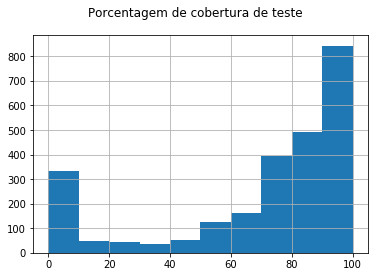

In [8]:
df_final['PORCENTAGEM_COBERTA'].hist()
plt.suptitle("Porcentagem de cobertura de teste")

## Filtro para remover cobertura abaixo de 20

mediana: 85.18518518518519
count    2534.000000
mean       69.797164
std        32.804781
min         0.000000
25%        58.887561
50%        81.496476
75%        94.444444
max       100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64


/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Porcentagem de teste')

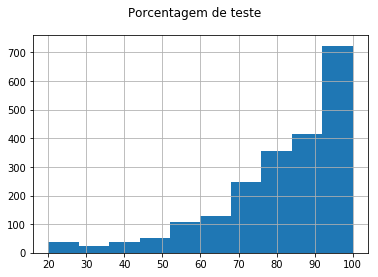

In [9]:
# Remove coberturas abaixo de 20%, pois de modo geral são classes apenas o construtor foi executado.
df_filtrada = df_final[df_final['PORCENTAGEM_COBERTA'] >= 20]
df_filtrada = df_filtrada[df_final['EST_CIVIL'] != 6]

#verifica
print("mediana: " + str(df_filtrada['PORCENTAGEM_COBERTA'].median()))
print(df_final['PORCENTAGEM_COBERTA'].describe())
df_filtrada['PORCENTAGEM_COBERTA'].hist()
plt.suptitle("Porcentagem de teste")

## Verifica usuários (únicos)

#### - Usuários únicos e total de ocorrências por usuário.

total de usuários únicos:155


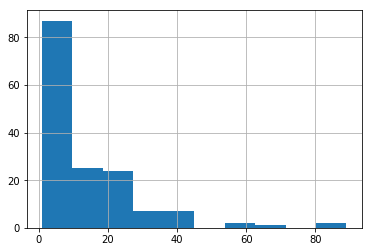

In [10]:
print("total de usuários únicos:" + str(len((df_filtrada['COD_USUARIO'].unique()))))
df_filtrada['COD_USUARIO'].value_counts().hist()

#### R: São diversos desenvolvedores, mas muitos possuem apenas 1 ocorrência de Cobertura de código testado.

### Verificações de idade de usuários 

Text(0.5, 0.98, 'Idade dos Desenvolvedores')

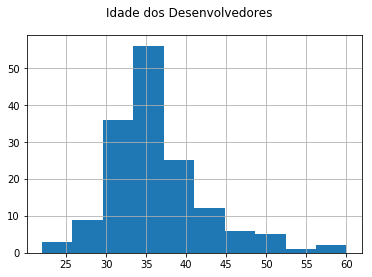

In [11]:
usuarios = df_filtrada.groupby('COD_USUARIO').tail(1)

#Verifica idade
usuarios['IDADE'].hist()
plt.suptitle("Idade dos Desenvolvedores")

### Verificações de tempo de empresa de usuários 

count    155.000000
mean       7.612903
std        4.360965
min        1.000000
25%        5.000000
50%        8.000000
75%       10.000000
max       31.000000
Name: TEMPO_EMPRESA, dtype: float64

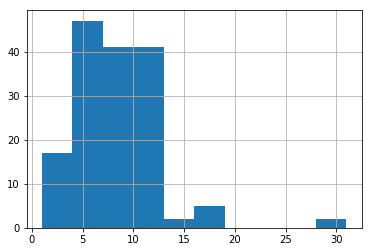

In [12]:
usuarios['TEMPO_EMPRESA'].hist()
usuarios['TEMPO_EMPRESA'].describe()

## Binning -> Porcentagem cobertura

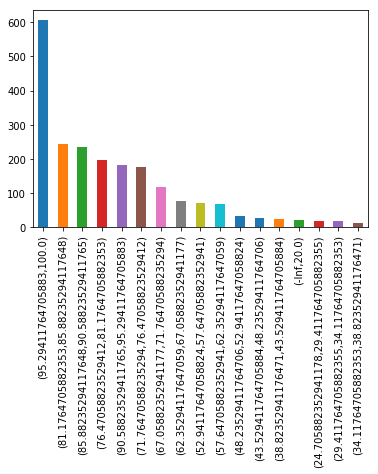

In [13]:
df_filtrada['BIN_PORCENTAGEM_COBERTA'] = binning(df_filtrada['PORCENTAGEM_COBERTA'])
df_filtrada['BIN_PORCENTAGEM_COBERTA'].value_counts().plot.bar()

In [14]:
df_filtrada['BIN_PORCENTAGEM_COBERTA'].value_counts()

(95.29411764705883,100.0)                  606
(81.1764705882353,85.88235294117648)       243
(85.88235294117648,90.58823529411765)      234
(76.47058823529412,81.1764705882353)       196
(90.58823529411765,95.29411764705883)      181
(71.76470588235294,76.47058823529412)      175
(67.05882352941177,71.76470588235294)      118
(62.35294117647059,67.05882352941177)       76
(52.94117647058824,57.64705882352941)       72
(57.64705882352941,62.35294117647059)       68
(48.23529411764706,52.94117647058824)       34
(43.529411764705884,48.23529411764706)      26
(38.82352941176471,43.529411764705884)      24
(-Inf,20.0)                                 20
(24.705882352941178,29.411764705882355)     19
(29.411764705882355,34.11764705882353)      18
(34.11764705882353,38.82352941176471)       13
Name: BIN_PORCENTAGEM_COBERTA, dtype: int64

### Categorização ESTADO CIVIL

In [15]:
def estado_civil(x):
    if x == 1:
        return "SOLTEIRO"
    elif x == 2:
        return "CASADO"
    else: return "DIVORCIADO"

df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].apply(lambda x : estado_civil(x))

In [16]:
df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].astype('category')

### Categorização -> Idade

In [17]:
def cria_classe_idade(x):
    if x < 30:
        return '20 anos'
    elif x >= 30 and x <= 40:
        return '30 anos'
    elif x > 40:
        return 'acima 40 anos'
    

df_filtrada['FAIXA_ETARIA'] = df_filtrada.apply(lambda x: cria_classe_idade(x['IDADE']), axis=1)
df_filtrada['FAIXA_ETARIA'] = df_filtrada['FAIXA_ETARIA'].astype('category')

### Binning idade

In [18]:
df_filtrada['BIN_IDADE'] = binning(df_filtrada['IDADE'])

### Categorização ERRO - ALERTA - OK
<br>A empresa considera: <br>-OK: acima de 80%<br>-ALERTA: entre 79% e 70%<br>-ERRO: abaixo de 70%

In [19]:
def ocorrencia(x):
    if x >= 80:
        return 'OK'
    elif x<80 and x>=70:
        return 'ALERTA'
    else: 
        return 'ERRO'

In [20]:
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada.apply(lambda x: ocorrencia(x['PORCENTAGEM_COBERTA']), axis=1)
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].astype('category')
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].cat.reorder_categories(['OK', 'ALERTA', 'ERRO'])

In [21]:
#df_filtrada[df_filtrada['TIPO_OCORRENCIA'].cat.codes == 2].head()

### Salva para weka

In [22]:
guardar = df_filtrada[df_filtrada['TIPO_OCORRENCIA'] == 'ERRO']
guardar.to_csv(r'/home/silva/desenvolvedor/export_dataframe.csv', index = None, header=True)

----------

# Verificação do DATASET tratado

### Verificação dos registros de cobertura de código de teste

### V1) Distribuição de idade dos desenvolvedores que gravaram registros

In [23]:
print("Tamanho amostra: {0}".format(len(df_filtrada)))

Tamanho amostra: 2123


Text(0.5, 0.98, 'Idade dos Desenvolvedores nas amostras')

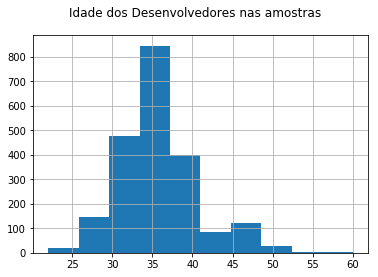

In [24]:
df_filtrada['IDADE'].hist()
plt.suptitle("Idade dos Desenvolvedores nas amostras")

In [25]:
print("mediana:" + str(df_filtrada['IDADE'].median()))
df_filtrada['IDADE'].describe()

mediana:35.0


count    2123.000000
mean       35.787565
std         5.000527
min        22.000000
25%        33.000000
50%        35.000000
75%        38.000000
max        60.000000
Name: IDADE, dtype: float64

### V2) Tempo de empresa dos desenvolvedores que gravaram registros

Text(0.5, 0.98, 'Tempo de empresa relativo aos registros gravados')

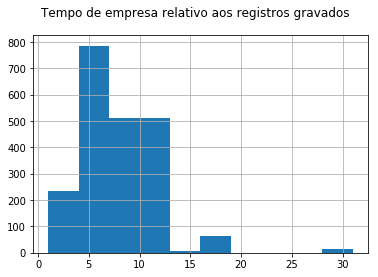

In [26]:
df_filtrada['TEMPO_EMPRESA'].hist()
plt.suptitle("Tempo de empresa relativo aos registros gravados")

In [27]:
print("mediana:" + str(df_filtrada['TEMPO_EMPRESA'].median()))
df_filtrada['TEMPO_EMPRESA'].describe()

mediana:8.0


count    2123.000000
mean        7.178050
std         3.841873
min         1.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        31.000000
Name: TEMPO_EMPRESA, dtype: float64

### V3) Faixa etária desenvolvedor

30 anos          1718
acima 40 anos     240
20 anos           165
Name: FAIXA_ETARIA, dtype: int64


Text(0.5, 0.98, 'Faixa etária desenvolvedor que gerou ocorrência')

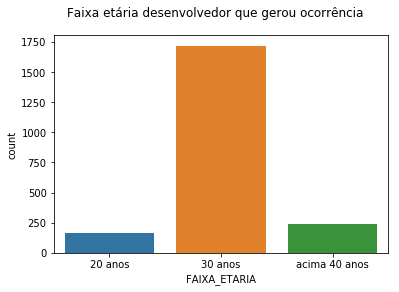

In [28]:
print(df_filtrada['FAIXA_ETARIA'].value_counts())
sns.countplot(df_filtrada['FAIXA_ETARIA'],label="Count")
plt.suptitle("Faixa etária desenvolvedor que gerou ocorrência")

In [29]:
df_20 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == '20 anos']
df_30 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == '30 anos']
df_40 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == 'acima 40 anos']

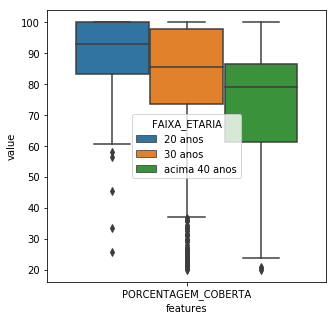

In [30]:
plot_boxplot(df_filtrada['FAIXA_ETARIA'], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, 'FAIXA_ETARIA')

### T) Teste de distribuições

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


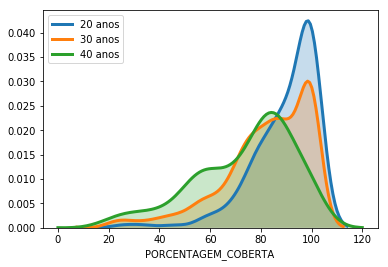

In [31]:
sns.distplot(df_20['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '20 anos')
sns.distplot(df_30['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '30 anos')
sns.distplot(df_40['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '40 anos')

In [32]:
print('median:' + str(df_20['PORCENTAGEM_COBERTA'].median()))
print(df_20['PORCENTAGEM_COBERTA'].describe())
print('----------------------')
print('median:' + str(df_30['PORCENTAGEM_COBERTA'].median()))
print(df_30['PORCENTAGEM_COBERTA'].describe())
print('----------------------')
print('median:' + str(df_40['PORCENTAGEM_COBERTA'].median()))
print(df_40['PORCENTAGEM_COBERTA'].describe())

median:93.02325581395348
count    165.000000
mean      89.519182
std       12.990635
min       25.523013
25%       83.467742
50%       93.023256
75%      100.000000
max      100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64
----------------------
median:85.41666666666667
count    1718.000000
mean       82.151822
std        17.388145
min        20.000000
25%        73.460478
50%        85.416667
75%        97.843619
max       100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64
----------------------
median:78.99574303405572
count    240.000000
mean      73.718148
std       19.355238
min       20.000000
25%       61.310393
50%       78.995743
75%       86.659607
max      100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64


## Distribuição homem x mulheres

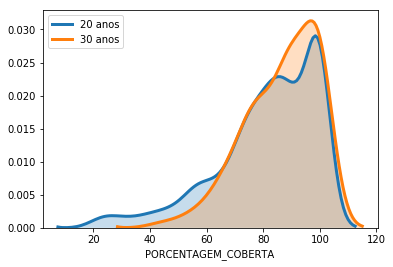

In [33]:
df_homens = df_filtrada[df_filtrada['SEXO'] == 'M']
df_mulheres = df_filtrada[df_filtrada['SEXO'] == 'F']

sns.distplot(df_homens['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '20 anos')
sns.distplot(df_mulheres['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '30 anos')

## Apriori - retirado do weka

------

### T0) Há diferença significativa entre as médias de homens e mulheres?

In [68]:
print(stats.kruskal(df_homens['PORCENTAGEM_COBERTA'], df_mulheres['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=7.551493995340784, pvalue=0.005996034198195007)


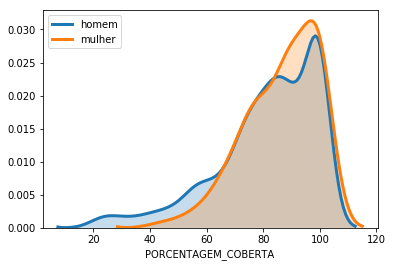

In [69]:
sns.distplot(df_homens['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'homem')
sns.distplot(df_mulheres['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'mulher')

In [66]:
df_sexo = unstack_group(df_filtrada, 'SEXO', ['TIPO_OCORRENCIA'])
df_sexo

SEXO,F,M
TIPO_OCORRENCIA,,
OK,101,1217
ALERTA,26,362
ERRO,17,400


In [67]:
chi2_contingency(df_sexo)

(6.449064962909699,
 0.039774372486844255,
 2,
 array([[  89.39802167, 1228.60197833],
        [  26.31747527,  361.68252473],
        [  28.28450306,  388.71549694]]))

### R0) temos indícios que a média de distribuição de porcentagem de código coberto, entre os sexos, é diferente. Pelo teste de kruskal-wallis, ao nível de significância de 5%, verificamos que devemos rejeitar a hipótese de que a distribuição possui a mesma média. Pelo gráfico e pela tabela de contingência, reparamos que a o sexo feminino possui uma concentração maior em ocorrências do Tipo Ok, ou seja, com porcentagem de código acima de 80%. Quanto ao grupo masculino, há uma maior disperção dos dados, quando comparado ao grupo de amostras do sexo feminino.

-------------------

### T1)Há diferença significativa entre as médias de homens e mulheres, usando apenas ALERTAS e OK?
#### Levando em consideração que porcentagens de cobertura tipificadas como ALERTAS e OK são aceitas para implantação em produção, verificamos 

In [104]:
df_homem_implantavel = df_homens[df_homens['TIPO_OCORRENCIA']!='ERRO']['PORCENTAGEM_COBERTA']
df_mulher_implantavel = df_mulheres[df_mulheres['TIPO_OCORRENCIA']!='ERRO']['PORCENTAGEM_COBERTA']
 
print(stats.kruskal(df_homem_implantavel, df_mulher_implantavel))

KruskalResult(statistic=1.2548133916163835, pvalue=0.26263513294083535)


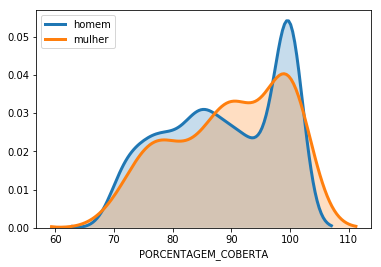

In [105]:
sns.distplot(df_homem_implantavel, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'homem')
sns.distplot(df_mulher_implantavel, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'mulher')

In [106]:
df_sexo = unstack_group(df_filtrada, 'SEXO', ['TIPO_OCORRENCIA'])
df_sexo = df_sexo.loc[['OK', 'ALERTA']]
df_sexo

SEXO,F,M
TIPO_OCORRENCIA,,
OK,101,1217
ALERTA,26,362


In [107]:
chi2_contingency(df_sexo)

(0.27516575552425043,
 0.5998874015652877,
 1,
 array([[  98.11606096, 1219.88393904],
        [  28.88393904,  359.11606096]]))

#### R1) Não temos indícios que a média de distribuição de porcentagem de código coberto entre os sexos, levando em conta apenas as porcentagens aceitas para implantação (marcadas como 'OK' ou 'ALERTA') são diferente. Pelo teste de kruskal-wallis, ao nível de significância de 5%, verificamos que não podemos rejeitar a hipótese de que a distribuição possui a mesma média. Pelo gráfico e pela tabela de contingência, reparamos que a dispersão dos dados são bem semelhantes. Tanto no teste de Kruskal-wallis ao comparar a distribuição das coberturas, quando no teste do qui-quadrado para verificar a frequência, não há indícios de diferença entre as amostras.

----------

### T2)Há diferença significativa entre as médias de homens e mulheres, usando apenas ERRO?

In [108]:
df_homem_erro = df_homens[df_homens['TIPO_OCORRENCIA']=='ERRO']['PORCENTAGEM_COBERTA']
df_mulher_erro = df_mulheres[df_mulheres['TIPO_OCORRENCIA']=='ERRO']['PORCENTAGEM_COBERTA']
 
print(stats.kruskal(df_homem_erro, df_mulher_erro))

KruskalResult(statistic=9.683961239068015, pvalue=0.0018588344568710446)


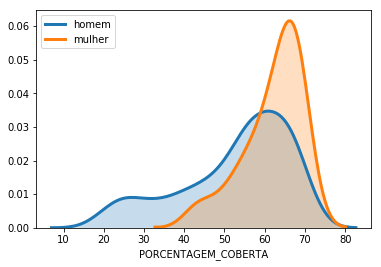

In [109]:
sns.distplot(df_homem_erro, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'homem')
sns.distplot(df_mulher_erro, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'mulher')

In [115]:
def bin_ocorrencia(x):
    if x == 'OK':
        return 'OK'
    return 'NOK'

df_sexo = df_filtrada[['SEXO', 'TIPO_OCORRENCIA']]
df_sexo['TIPO_OCORRENCIA_BINARIA'] = df_sexo['TIPO_OCORRENCIA'].apply(lambda x: bin_ocorrencia(x))
df_sexo = unstack_group(df_sexo, 'SEXO', ['TIPO_OCORRENCIA_BINARIA'])

df_sexo

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


SEXO,F,M
TIPO_OCORRENCIA_BINARIA,,
NOK,43,762
OK,101,1217


In [116]:
chi2_contingency(df_sexo)

(3.900597664258716,
 0.048268933367307476,
 1,
 array([[  54.60197833,  750.39802167],
        [  89.39802167, 1228.60197833]]))

#### Corroborando o algorimto apriori, que demonstra 15,7% (400) do total de amostras sejam relacionadas a homens que cometeram "erros" de cobertura de código (pela definição da empresa), existem evidências de diferença entre as médias entre homens e mulheres nessa faixa de cobertura (erro), o que leva a crer que o sexo masculino tem uma tendência maior a produzir coberturas com porcentagens menores. 

--------------

### T3) Há diferença significativa entre as médias de cobertura entre solteiros e casados?

In [123]:
df_solteiros = df_filtrada[df_filtrada['EST_CIVIL']== 'SOLTEIRO']['PORCENTAGEM_COBERTA']
df_casados = df_filtrada[df_filtrada['EST_CIVIL']== 'CASADO']['PORCENTAGEM_COBERTA']
 
print(stats.kruskal(df_solteiros, df_casados))

KruskalResult(statistic=4.793712917107758, pvalue=0.028563790495206055)


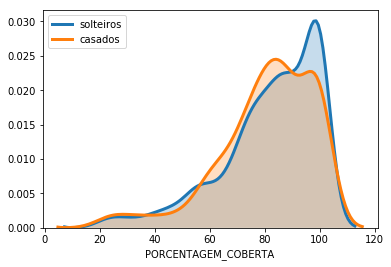

In [124]:
sns.distplot(df_solteiros, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'solteiros')
sns.distplot(df_casados, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'casados')

In [130]:
df_estcivil = unstack_group(df_filtrada, 'EST_CIVIL', ['TIPO_OCORRENCIA'])
df_estcivil

EST_CIVIL,CASADO,SOLTEIRO
TIPO_OCORRENCIA,,
OK,279,1039
ALERTA,92,296
ERRO,97,320


In [132]:
chi2_contingency(df_estcivil)

(1.5752620620505215,
 0.4549212140196165,
 2,
 array([[ 290.54357042, 1027.45642958],
        [  85.53179463,  302.46820537],
        [  91.92463495,  325.07536505]]))

### R03 - embora não há existam evidências de diferença na frequência de ocorrências, quando comparado casados com solteiros,  rejeitamos a hipótese de que não há diferença significativa entre as médias de distribuição das porcentagens de cobertura.   

----------------

### T2)Há diferença significativa entre as médias das distribuições entre as 3 faixas etárias?

In [119]:
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=88.29236422112848, pvalue=6.722900942903351e-20)
KruskalResult(statistic=32.41167259623873, pvalue=1.2473497559800273e-08)
KruskalResult(statistic=84.17282872786805, pvalue=4.53358719540117e-20)
KruskalResult(statistic=47.06856027076317, pvalue=6.854645976955679e-12)


#### RT2) Pelo teste de Kruskal wallis, rejeita-se a hipótese nula, pois há indícies que a média das distribuições são diferentes, quando se leva em conta a faixa etaria. Há indícios de diferença significativa. 

----

### T4)Entre mesmas faixas etárias, há diferença na média de cobertura, quando comparado homens com mulheres?

In [133]:
print('Cobertura - Homens de 20 anos x  Mulheres de 20 anos')
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print('\n')
print('----------------')
print('Cobertura - Homens de 30 anos x  Mulheres de 30 anos')
print(stats.kruskal(df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print('\n')
print('----------------')
print('Cobertura - Homens de 40 anos x  Mulheres de 40 anos')
print(stats.kruskal(df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))

Cobertura - Homens de 20 anos x  Mulheres de 20 anos
KruskalResult(statistic=0.09776500328051212, pvalue=0.7545283836044219)


----------------
Cobertura - Homens de 30 anos x  Mulheres de 30 anos
KruskalResult(statistic=7.237025988898016, pvalue=0.0071415176471908235)


----------------
Cobertura - Homens de 40 anos x  Mulheres de 40 anos
KruskalResult(statistic=0.42063490403141873, pvalue=0.5166204094200435)


#### RT2: Existe diferença significativa apenas na faixa etária de 30 anos, entre os sexos

### T3)Verificação de diferença nas distribuições entre faixa etária (dividido por sexo)

In [134]:
print('Masculino: 20 anos <-> 30 anos')
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA']))
print('---------')
print('Masculino: 20 anos <-> 40 anos')
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA']))
print('---------')
print('Masculino: 30 anos <-> 40 anos')
print(stats.kruskal(df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA']))

Masculino: 20 anos <-> 30 anos
KruskalResult(statistic=33.72860864183158, pvalue=6.336196796192806e-09)
---------
Masculino: 20 anos <-> 40 anos
KruskalResult(statistic=81.90997722993666, pvalue=1.424284830997749e-19)
---------
Masculino: 30 anos <-> 40 anos
KruskalResult(statistic=42.67074598493471, pvalue=6.477378897842572e-11)


#### RT3.1: Olhando apenas a população masculina, existe diferença significativa em todas as faixas etárias

In [135]:
print(stats.kruskal(df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=0.11185715620916344, pvalue=0.738039615870417)
KruskalResult(statistic=3.147482014388489, pvalue=0.07604422422008318)
KruskalResult(statistic=2.3184464203742117, pvalue=0.12784765808273382)


#### RT3.2: Não existem diferenças significativa entre as faixas etárias, dentro do sexo feminino

### T4)Verificação da existência de diferença nas distribuições, usando apenas erros

In [136]:
df_20_erro_masculino = df_20[(df_20['SEXO']=='M') & (df_20['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']
df_30_erro_masculino = df_30[(df_30['SEXO']=='M') & (df_30['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']
df_40_erro_masculino = df_40[(df_40['SEXO']=='M') & (df_40['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']
df_20_erro_feminino = df_20[(df_20['SEXO']=='F') & (df_20['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']
df_30_erro_feminino = df_30[(df_30['SEXO']=='F') & (df_30['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']
df_40_erro_feminino = df_40[(df_40['SEXO']=='F') & (df_40['TIPO_OCORRENCIA']!='ERRO')]['PORCENTAGEM_COBERTA']

print(stats.kruskal(df_20_erro_masculino, df_20_erro_feminino))
print(stats.kruskal(df_30_erro_masculino, df_30_erro_feminino))
print(stats.kruskal(df_40_erro_masculino, df_30_erro_feminino))

KruskalResult(statistic=0.3871363839438021, pvalue=0.5338084936351963)
KruskalResult(statistic=3.100173573615762, pvalue=0.07828394712441211)
KruskalResult(statistic=17.092461483715827, pvalue=3.560334634752513e-05)


In [137]:
### R4

In [138]:
print(stats.kruskal(df_40_erro_masculino, df_30_erro_feminino))

KruskalResult(statistic=17.092461483715827, pvalue=3.560334634752513e-05)


----------

## Verificações Qui-quadrado (bastante dúvidas)

### Q1- Faixa etária - Sexo - Estado civil = Ocorrencia Erro | Alerta

In [45]:
df1 = unstack_group(df_filtrada, 'FAIXA_ETARIA', ['TIPO_OCORRENCIA', 'SEXO', 'EST_CIVIL'])
df1 = df1.loc[['ERRO', 'ALERTA']]
df1

FAIXA_ETARIA                    20 anos  30 anos  acima 40 anos
TIPO_OCORRENCIA SEXO EST_CIVIL                                 
ALERTA          F    SOLTEIRO       1.0     19.0            6.0
                M    CASADO         9.0     71.0           12.0
                     SOLTEIRO      13.0    235.0           22.0
ERRO            F    SOLTEIRO       0.0     17.0            0.0
                M    CASADO         1.0     79.0           17.0
                     SOLTEIRO       9.0    228.0           66.0

In [46]:
chi2_contingency(df1)

(36.66532766060744,
 6.465436534732422e-05,
 10,
 array([[  1.06583851,  20.96149068,   3.97267081],
        [  3.77142857,  74.17142857,  14.05714286],
        [ 11.06832298, 217.67701863,  41.25465839],
        [  0.69689441,  13.70559006,   2.59751553],
        [  3.97639752,  78.20248447,  14.82111801],
        [ 12.42111801, 244.28198758,  46.29689441]]))

#### R1: Há indícios de das variáveis serem dependentes.

### Q2- Faixa etária - Sexo - Estado civil = Ocorrencia Erro | Alerta

In [47]:
df1 = unstack_group(df_filtrada, 'FAIXA_ETARIA', ['TIPO_OCORRENCIA', 'SEXO', 'EST_CIVIL'])
df1 = df1.loc['ERRO']
df1

FAIXA_ETARIA    20 anos  30 anos  acima 40 anos
SEXO EST_CIVIL                                 
F    SOLTEIRO       0.0     17.0            0.0
M    CASADO         1.0     79.0           17.0
     SOLTEIRO       9.0    228.0           66.0

In [48]:
chi2_contingency(df1)

(7.2712636125120405,
 0.12222895600068359,
 4,
 array([[  0.40767386,  13.20863309,   3.38369305],
        [  2.32613909,  75.36690647,  19.30695444],
        [  7.26618705, 235.42446043,  60.30935252]]))